### 載入所需的Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [32]:
# read data from spam.csv
sms_data = pd.read_csv('spam.csv', encoding='ISO-8859-1')
###<your code>###
sms_data = sms_data[['v1','v2']]
sms_data.columns = ['label', 'content']
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [33]:
# check how many spams and hams
###<your code>###
pd.DataFrame(sms_data.groupby('label')['content'].count())

,content
label,
ham,4825
spam,747


In [34]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1
sms_data['label'] = sms_data['label'].map(lambda s: 1 if s == 'spam' else 0 )
###<your code>###
sms_data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 切分資料
將資料依據label比例切分為training data與testing data

In [66]:
###<your code>###
sms_train, sms_test = train_test_split(sms_data, test_size=0.2, stratify=sms_data.label)
print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       content
label         
0         3859
1          598
       content
label         
0          966
1          149


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [67]:
sms_train = sms_train.reset_index()
sms_test = sms_test.reset_index()

In [68]:
sms_train

,index,label,content
0,4856,0,Thanks and ! Or bomb and date as my phone wan...
1,5490,0,K. I will sent it again
2,622,0,MAKE SURE ALEX KNOWS HIS BIRTHDAY IS OVER IN F...
3,3067,0,Boy you best get yo ass out here quick
4,4774,0,So many people seems to be special at first si...
...,...,...,...
4452,3732,0,Old Orchard near univ. How about you?
4453,1434,0,I asked sen to come chennai and search for job.
4454,3305,0,HI DARLIN I FINISH AT 3 DO U 1 2 PICK ME UP OR...
4455,2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [69]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)):
        # make all content to lowercase
        ###<your code>###
        df['content'][i] = df['content'][i].lower()
        # remove all punctuations
        ###<your code>###
        df['content'][i] =  re.sub(r'[^\w\s]', '', df['content'][i])
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

<ipython-input-69-cdd259993346>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'][i] = df['content'][i].lower()
<ipython-input-69-cdd259993346>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'][i] =  re.sub(r'[^\w\s]', '', df['content'][i])


Train:
   index  label                                            content
0   4856      0  thanks  and  or bomb and date as my phone want...
1   5490      0                             k i will sent it again
2    622      0  make sure alex knows his birthday is over in f...
3   3067      0             boy you best get yo ass out here quick
4   4774      0  so many people seems to be special at first si...
Test:
   index  label                                            content
0    158      1  customer service annoncement you have a new ye...
1   2061      0  hey  i want you  i crave you  i miss you  i ne...
2   1582      0         yep at dereks house now see you sunday lt3
3   4493      0  man this bus is so so so slow i think youre go...
4   5274      0  hi hope ur day  good back from walk table book...


In [70]:
del processed_train['index']
del processed_test['index']

In [71]:
processed_train

,label,content
0,0,thanks and or bomb and date as my phone want...
1,0,k i will sent it again
2,0,make sure alex knows his birthday is over in f...
3,0,boy you best get yo ass out here quick
4,0,so many people seems to be special at first si...
...,...,...
4452,0,old orchard near univ how about you
4453,0,i asked sen to come chennai and search for job
4454,0,hi darlin i finish at 3 do u 1 2 pick me up or...
4455,1,free entry in 2 a wkly comp to win fa cup fina...


In [72]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

9564

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [75]:
vectorizer = TfidfVectorizer(max_features= 2000) 
## 用X_train來build 字典，字數還有document 數量
vectorizer.fit(x_train)

## 得到tfidf vector
tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 49575 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12015 stored elements in Compressed Sparse Row format>)

### 建立共現矩陣

In [76]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    vocab_size = len(vocab_list)
    co_matrix = np.zeros(shape=(vocab_size, vocab_size))
    
    for idx, sms in enumerate(corpus):
        sms = sms.split()
        sms_ids = [word2idx[word] for word in sms if word in vocab_list] #tokenize
        
        for center_i, center_word_id in enumerate(sms_ids):
            context_ids = sms_ids[max(0, center_i - window_size):center_word_id]
            content_len = len(context_ids)
            
            for left_i, left_word_id in enumerate(context_ids):
                
                if use_weighting:
                    distance = content_len - left_i
                    increment = 1./float(distance)
                else:
                    increment = 1
                    
                co_matrix[center_word_id, left_word_id] += increment
                co_matrix[left_word_id, center_word_id] += increment
        
        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        np.fill_diagonal(co_matrix, 1.)
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix


finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### 建立PPMI矩陣

In [77]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]

    cnt = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

<ipython-input-77-5818689276d9>:13: RuntimeWarning: divide by zero encountered in log2
  pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))


array([[8.628004 , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.8334174, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 3.6290987, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 3.5306947, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 5.1796117,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        8.0397005]], dtype=float32)

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.8776909516239632
Number of components = 20 and explained variance = 0.9055627067564593
Number of components = 30 and explained variance = 0.9218351197225779
Number of components = 40 and explained variance = 0.9329362801286808
Number of components = 50 and explained variance = 0.9412580645640233
Number of components = 60 and explained variance = 0.9478939335138727
Number of components = 70 and explained variance = 0.9532348690854299
Number of components = 80 and explained variance = 0.9575087391572308
Number of components = 90 and explained variance = 0.9611676113993811
Number of components = 100 and explained variance = 0.9644049070473697
Number of components = 110 and explained variance = 0.9672372486355002
Number of components = 120 and explained variance = 0.969735022570611
Number of components = 130 and explained variance = 0.9719516087989067
Number of components = 140 and explained variance = 0.9739166002905444


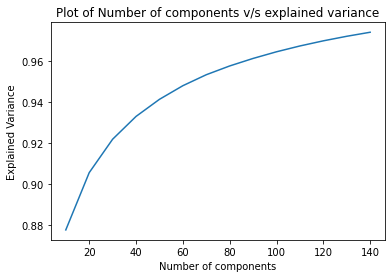

In [78]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print(f"Number of components = {dim} and explained variance = {svd.explained_variance_ratio_.sum()}")
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [79]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
###<your code>###
# choose 140 as final dimension to reduce to
svd = TruncatedSVD(n_components=140)
svd.fit(co_matrix)
re_co_matrix = svd.transform(co_matrix)

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [80]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 249 doesn't contain word in vocab_list
staffsciencenusedusgphyhcmkteachingpc1323


document 312 doesn't contain word in vocab_list
 


document 410 doesn't contain word in vocab_list
hanks lotsly


document 792 doesn't contain word in vocab_list
s sfirst timedhoni rocks


document 967 doesn't contain word in vocab_list
645


document 1417 doesn't contain word in vocab_list
ringtoneking 84484


document 1647 doesn't contain word in vocab_list
 


document 1765 doesn't contain word in vocab_list
nonenowhere ikno doesdiscountshitinnit


document 1810 doesn't contain word in vocab_list
22 146tf150p


document 2118 doesn't contain word in vocab_list
u 2


document 2444 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli


document 2773 doesn't contain word in vocab_list
gibbs unsoldmike hussey


document 2885 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 3028 doesn't contain word in vocab_list
audrie lousy auto

In [81]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(doc_vec_train, y_train_filter)
train_pred = knn.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
test_pred = knn.predict(doc_vec_test)

In [82]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9684542586750788
train acc: 0.954954954954955
